## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Authors: 
 - Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a>
 - Naeem Payeedeh    
</font> 

### Comparison of  Momentum methods in Optimizing a Stochastic Quadratic Function

Assume that the objective function is 
$$
E(x,y)=
\left[\begin{array}{l}x & y\end{array}\right]
E[R+\Delta R]
\left[\begin{array}{l}x \\ y\end{array}\right]
+E[P + \Delta P] ^T \left[\begin{array}{l}x \\ y\end{array}\right]
$$

where 

$$
\begin{array}{l}
&R = Q \Lambda Q^T \\
&\Lambda = \left[\begin{array}{ll}
\lambda_1 & 0 \\
0 & \lambda_2
\end{array}\right]\\
&Q = \left[\begin{array}{ll}
cos(\theta) & sin(\theta) \\
-sin(\theta) & cos(\theta)
\end{array}\right]\\
\end{array}
$$

and 

$$
E[\Delta R] = 0
$$

In [62]:
import numpy as np
import math
import matplotlib as mpl
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [77]:
lambda_1 = 1.0
lambda_2 = 1.0
theta = np.pi / 4
Q = np.array([[math.cos(theta), math.sin(theta)],
              [-math.sin(theta), math.cos(theta)]])
P = np.array([[-4],[-2]])
Lambda = np.array([[lambda_1, 0],
                   [0, lambda_2]])
R = Q @ Lambda @ Q.T

In [80]:
xs = np.arange(-4, 4, 0.1)
ys = np.arange(-4, 4, 0.1)
E = np.ndarray([len(xs),len(ys)])
for i, x in enumerate (xs):
    for j, y in enumerate(ys):
        p = np.array([x,y])
        E[i,j] = p @ R @ p.T + P.T @ p
X, Y = np.meshgrid(xs, ys)

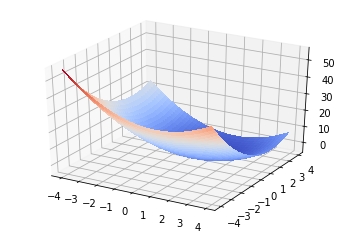

In [81]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, E, 
                       cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

## Minimization using Stochastic Gradient Descent

We have:
    $$\nabla{E}=2 (R+\Delta R) \left[\begin{array}{l} x\\ y \end{array}\right]  + P + \Delta P$$

The update rule for the gradient descent algorithm is:

$$\left[\begin{array}{l}x^{new}\\y^{new}\end{array}\right] = 
\left[\begin{array}{l}x^{old}\\y^{old}\end{array}\right]
- \mu \left(2(R+\Delta R) \left[\begin{array}{l} x^{old}\\ y^{old} \end{array}\right] + P + \Delta P\right) $$

### Momentum stochastic gradient descent algorithms

In [82]:
np.random.seed(0)
T = 10000
max_learning_rate = 1.0 / max(lambda_1, lambda_2)
lr = max_learning_rate * 0.5
lr *= 1
lrAdam = lr
lrRMSProp = lr
mom = 0.9
lrMom = lr * (1-mom) # We scale learning rates for momentum by (1-mom)

beta1 = 0.9
beta2 = 0.999
eps = 1e-8
epsAdaDelta = 1e-3

wSGD = np.zeros([T,2])
wMomentum = np.zeros([T,2])
wNAG = np.zeros([T,2])
wRMSProp = np.zeros([T,2])
wAdam = np.zeros([T,2])
wAdaGrad = np.zeros([T,2])
wAdaDelta = np.zeros([T,2])

weightHistories = {
    'SGD' : wSGD, 
    'Momentum' : wMomentum, 
    'NAG' : wNAG, 
    'RMSProp' : wRMSProp, 
    'Adam': wAdam, 
    'Adagrad' : wAdaGrad, 
    'AdaDelta': wAdaDelta
}

for weight in weightHistories.values():
    weight[0,0] = -2.0
    weight[0,1] = 3.0
    
vMomentum = np.zeros([1, 2])
vNAG = np.zeros([1, 2])
movingSqRMSProp = np.zeros([1, 2])
VAdam = np.zeros([1, 2])
SAdam = np.zeros([1, 2])
SumGradSqAdaGrad = np.zeros([1, 2])
mvDeltaWAdaDelta = np.zeros([1, 2])
mvGradAdaDelta = np.zeros([1, 2])

for i in range (1,T):
    deltaR = np.random.randn(2, 2) * 0
    noisyR = R + (deltaR + deltaR.T) / 2
    deltaP = + np.random.randn(2, 1) * 0
    noisyP = P + deltaP
    
    gradSGD   = 2 * noisyR @ wSGD[i-1, :, None] + noisyP
    wSGD[i,:] = wSGD[i-1, :] - lr * gradSGD[:,0]
    
    gradMomentum   = 2 * noisyR @ wMomentum[i-1, :, None] + noisyP
    vMomentum = mom * vMomentum - lrMom * gradMomentum[:,0]
    wMomentum[i,:] = wMomentum[i-1,:] + vMomentum
    
    gradNAG   = 2 * noisyR @ (wNAG[i-1, :] + mom * vNAG).T + noisyP
    vNAG = mom * vNAG - lrMom * gradNAG[:,0]
    wNAG[i,:] = wNAG[i-1, :] + vNAG
    
    gradRMSProp   = 2 * noisyR @ wRMSProp[i-1, :, None] + noisyP
    movingSqRMSProp = beta1 * movingSqRMSProp \
                    + (1-beta1) * gradRMSProp[:,0] ** 2 # Mr Hinton's suggestion
    wRMSProp[i,:] = wRMSProp[i-1,:] \
                  - lrMom * gradRMSProp[:,0] / np.sqrt(movingSqRMSProp+eps)

    gradAdam   = 2 * noisyR @ wAdam[i-1,:, None] + noisyP
    VAdam = beta1 * VAdam + (1-beta1) * gradAdam[:,0]
    SAdam = beta2 * SAdam + (1-beta2) * gradAdam[:,0] ** 2
    VAdamCorrected = VAdam[0] / (1 - beta1 ** i)
    SAdamCorrected = SAdam[0] / (1 - beta2 ** i)
    wAdam[i,:] = wAdam[i-1,:] \
                - lrAdam * VAdamCorrected / (np.sqrt(SAdamCorrected) + eps) # Trivial
    
    gradAdaGrad   = 2 * noisyR @ wAdaGrad[i-1, : , None] + noisyP
    SumGradSqAdaGrad = SumGradSqAdaGrad + gradAdaGrad[:,0] ** 2
    wAdaGrad[i,:] = wAdaGrad[i-1,:] \
                    - lr * gradAdaGrad[:,0] / np.sqrt(SumGradSqAdaGrad)

    gradAdaDelta   = 2 * noisyR @ wAdaDelta[i-1, :, None] + noisyP
    mvGradAdaDelta = beta1 * mvGradAdaDelta \
                    + (1-beta1) * gradAdaDelta[:,0] ** 2
    DeltaW = - np.sqrt(mvDeltaWAdaDelta + epsAdaDelta) / np.sqrt(mvGradAdaDelta + epsAdaDelta) \
            * gradAdaDelta[:,0]
    wAdaDelta[i,:] = wAdaDelta[i-1,:] + DeltaW
    mvDeltaWAdaDelta = beta1 * mvDeltaWAdaDelta \
                    + (1-beta1) * DeltaW ** 2

In [83]:
def show_plot(weightHistories, names, num=-1):
    plt.figure(figsize=[10,10])
    ax = plt.subplot(111, aspect='equal')
    for scale in np.arange(10):
        width = scale / np.sqrt(lambda_1)
        height = scale / np.sqrt(lambda_2)
        e = Ellipse(-1/2*P, width, height, -theta * 180 / np.pi
               , facecolor = 'none', edgecolor = 'r')
        ax.add_artist(e)

    for name in names:
        weight = weightHistories[name][0:num, :]
        x = weight[:,0]
        y = weight[:,1]
        plt.plot(x,y, label = name)
        plt.plot(x[-1],y[-1], '*r')
        plt.xlim(-4,4)
        plt.ylim(-4,4)
        #print(x[T-1])
        #print(y[T-1])
    plt.legend()
    plt.show()  

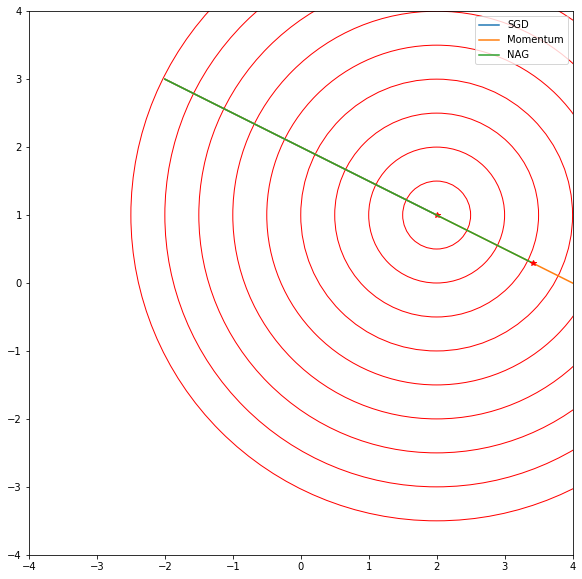

In [84]:
show_plot(weightHistories, ['SGD', 'Momentum', 'NAG'], 10)

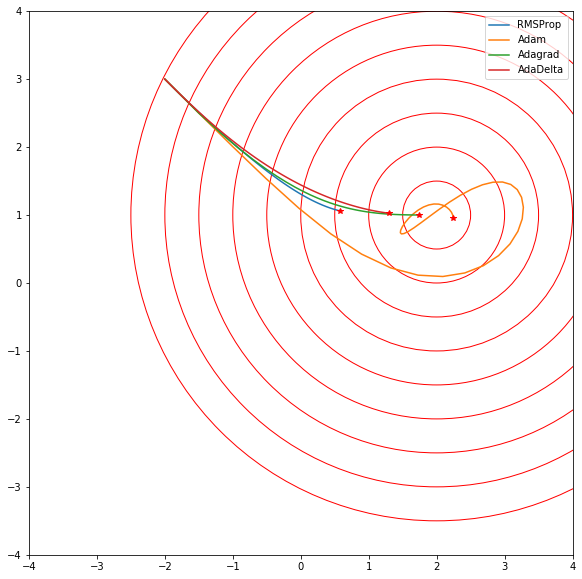

In [85]:
show_plot(weightHistories, ['RMSProp', 'Adam', 'Adagrad', 'AdaDelta'], 50)